In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import svm
from scipy.optimize import root_scalar

In [2]:
def Kernel(J_train):
    """Fidelity for the Analytic Kernel"""

    def cos2theta(k, J):
        cosk = np.cos(k)
        cos2a = (1 + 2*J*cosk)/np.sqrt(1 + 4*J*cosk + 4*J**2)
        return cos2a

    def cos(k, J1, J2):
        a = 0.5*np.arccos(cos2theta(k, J1))
        b = 0.5*np.arccos(cos2theta(k, J2))
        cosJ1J2 = np.cos(a - b)
        return cosJ1J2

    def F(J1, J2):
        F = 1
        nmax = int(N*0.5) + 1
        for n in range(1, nmax):   
            k = (2*n - 1)*np.pi/N
            F = F*abs(cos(k, J1, J2))
        return F

    x = len(J_train)
    K = np.ones((x, x), dtype=np.float64, order='C')

    for i in range(x):
        for j in range(i, x):
            if i == j:
                K[i, j] = 1
            else:
                K[i, j] = F(J_train[i], J_train[j])
                K[j, i] = K[i, j]
    return K



def gram(J1, J2):
    """Fidelity for the Analytic Gram matrix"""

    def cos2theta(k, J):
        cosk = np.cos(k)
        cos2a = (1 + 2*J*cosk)/np.sqrt(1 + 4*J*cosk + 4*J**2)
        return cos2a

    def cos(k, J1, J2):
        a = 0.5*np.arccos(cos2theta(k, J1))
        b = 0.5*np.arccos(cos2theta(k, J2))
        cosJ1J2 = np.cos(a - b)
        return cosJ1J2

    def F(J1, J2):
        F = 1
        nmax = int(N*0.5) + 1
        for n in range(1, nmax):   
            k = (2*n - 1)*np.pi/N
            F = F*abs(cos(k, J1, J2))
        return F

    y = len(J2)
    G = np.ones(shape=y, dtype=np.float64, order='C')

    for i in range(y):
        G[i] = F(J1, J2[i])
                
    return G.reshape(1, -1)



def distance(J):
    """Distance function using the decision_function method from sklearn"""

    G = gram(J, J_train)
    d = clf.decision_function(G)

    return float(d)



def J_critical():
    """Minimize the distance function in order to find Jc"""

    results = root_scalar(distance, bracket=(sv[0], sv[-1]))

    if not results.converged:
        raise Exception(results.flag)
    else:
        return results.root



def save_JcVSN(delta):
    """Hope you have enough money to buy some indulgences and be saved.
    Save J_[c] VS N in columns'
    """

    f = open(f'/home/luca/quantum_computing/Qiskit/Projects/QSVM4QPT/results/noiseless/JcVSN_anal_{delta}.txt', 'a')

    f.write(str(round(Jc, 3)) + ', ')
    f.write(str(N) + ', ')

    f.write('\n')
    f.close()

In [5]:
Nmin = 4
Nmax = 1000
Nlist = [x for x in range(Nmin, 10, 2)]
Nlist1 = [x for x in range(10, 100, 10)]
Nlist2 = [x for x in range(100, Nmax + 1, 100)]
Nlist = Nlist + Nlist1 + Nlist2

#delta is the training interval.
#delta = 1 --> (0.8, 0.9) U (1.2, 1.3)
#delta = 2 --> (0.6, 0.7) U (1.6, 1.7)
#delta = 3 --> 133 point Randomly distribuited over (0.25, 1.75)
delta = 3
#J_train = [0.6 + d*0.0015 for d in range(66)]
#J_train2 = [1.6 + d*0.0015 for d in range(67)]
#J_train = J_train + J_train2
rng = default_rng(1)
"""whatch out! For the random distribution it's not allways true that sv[0] and sv[-1] will have different signs, it depends on the seed"""

J_train = [0.25 + 1.5*rng.random() for i in range (133)]
y_train = [-1 if x < 1 else 1 for x in J_train]

for N in Nlist:
    
    #compute the Kernel
    K = Kernel(J_train)
    #Train the SVM for classification
    clf = svm.SVC(kernel='precomputed', cache_size=1000)
    clf.fit(K, y_train)

    #support vectors info
    sv = [J_train[i] for i in clf.support_]
    ys = np.reshape(y_train, (len(y_train), 1))[clf.support_]
    al = np.abs(clf.dual_coef_[0])
    M  = len(sv)

    #find J_{c}
    Jc = J_critical()
    #save_JcVSN(delta)
    #print(Jc)

In [ ]:
def HarryPlotter_dvsJ(N):
    """It's magick as Fuck, it can even plot your soul (but is not a psychotherapist)"""

    a = np.genfromtxt(f'results/noiseless/distVSJ{N}.txt', delimiter=',')
    a2 = np.genfromtxt(f'results/noiseless/distVSJ{N}_SV.txt', delimiter=',')
    J = a[:, 0]
    d = a[:, 1]
    J_sv = a2[:, 0]
    d_sv = a2[:, 1]

    fig, ax = plt.subplots(figsize=(5,4), layout='constrained')

    ax.set_xlabel("J", size=15)
    ax.set_ylabel("distance", size=15)
    ax.set_title(f'd V.s. J for N = {N}')
    ax.text((Jc + 0.1), -0.2, r'$J_{c} =$' + str(round(Jc, 3)))

    ax.text(J_train[len(J_train)//2], 0.1, r'$\delta J_{1}$', c='dimgray', size=15)
    ax.text(J_train[0], 0.1, r'$\delta J_{2}$', c='dimgray', size=15)
    ax.axvspan(J_train[0], J_train[len(J_train)//2-1], alpha=0.5, color='gainsboro')
    ax.axvspan(J_train[len(J_train)//2], J_train[len(J_train)-1], alpha=0.5, color='lightgrey')

    ax.plot(J, d, c='midnightblue', label=f'd N={N}')
    ax.plot(J, np.zeros(len(J)), c='dimgray', linestyle=':')
    ax.scatter(np.round(sv_J, 1), np.round(d_sv), facecolor='None', edgecolor='midnightblue', s=40, label=f'SV N={N}')
    plt.legend()
    #plt.savefig(f'results/noiseless/dVSJ{N}.pdf', bbox_inches='tight')

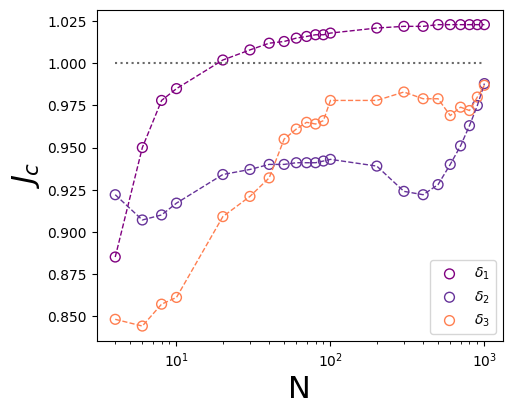

In [10]:
c = ['purple', 'rebeccapurple', 'coral']
fig, ax = plt.subplots(figsize=(5,4), layout='constrained')

ax.set_ylabel(r"$J_{c}$", size = 22)
ax.set_xlabel("N", size = 22)
ax.set_xscale('log')

ax.plot(Nlist, np.ones(22), c='dimgray', linestyle=':')

for i in range(3):
    file = np.genfromtxt(f'/home/luca/quantum_computing/Qiskit/Projects/QSVM4QPT/results/noiseless/JcVSN_anal_{i+1}.txt', delimiter=',')
    Jy = file[:, 0]

    ax.plot(Nlist, Jy, linestyle='--', c=f'{c[i]}', linewidth=1)
    ax.scatter(Nlist, Jy, s=50, facecolor='none', edgecolors=f'{c[i]}', label=rf"$\delta_{i+1}$")

plt.legend()
plt.savefig(f'/home/luca/quantum_computing/Qiskit/Projects/QSVM4QPT/results/noiseless/JcVSN_anal.pdf', bbox_inches='tight')

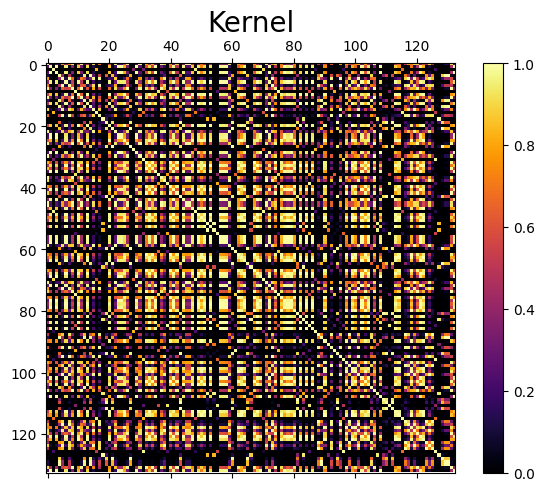

In [6]:
def plot_Kmatrix(K):
    """Plot the Kernel"""

    fig = plt.figure(layout='constrained')
    ax = fig.add_subplot()
    #cax = ax.matshow(K, cmap=plt.cm.get_cmap('cividis', ), interpolation='nearest')
    cax = ax.matshow(K, cmap=mpl.colormaps['inferno'], interpolation='nearest')
    fig.colorbar(cax)

    ax.set_title('Kernel', size=20)
    #plt.savefig(f'results/noiseless/Kernel{N}_anal_{delta}.pdf', bbox_inches='tight')

plot_Kmatrix(K)